For the XGBoost we will test on tf-idf, both with and without balanced class, check on styling features, and all combined together.

Feature setups:

    TF-IDF only

    TF-IDF + balancing (ROS)

    TF-IDF + balancing + stylistic features

For balance, use ROS, as it works good on modertae imbalance. Test set will remain untouched.

In [40]:
from src.utils import load_cleaned_data, metrics, plot_confusion_matrix, store_metrics
import pandas as pd
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack, csr_matrix


Setup for storing metrics & features

In [41]:
results = []
style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']

train_df = pd.read_csv("data/byarticle_clean.tsv", sep="\t")
test_df = pd.read_csv("data/byarticle_clean_test.tsv", sep="\t")

train_df_lem = pd.read_csv("data/byarticle_train_lemmatized.tsv", sep="\t")
test_df_lem = pd.read_csv("data/byarticle_test_lemmatized.tsv", sep="\t")

In [42]:
# Create experiment configurations
experiments = [
    {
        "name": "TF-IDF(2000) + scale_weight",
        "train_df": train_df,
        "test_df": test_df,
        "text_col": "full_text",
        "max_features": 2000,
        "style": False,
        "balancing": "weight"
    },
    {
        "name": "TF-IDF(2000) + Style + scale_weight",
        "train_df": train_df,
        "test_df": test_df,
        "text_col": "full_text",
        "max_features": 2000,
        "style": True,
        "balancing": "weight"
    },
    {
        "name": "TF-IDF(2000) + Style + ROS",
        "train_df": train_df,
        "test_df": test_df,
        "text_col": "full_text",
        "max_features": 2000,
        "style": True,
        "balancing": "ros"
    },
    {
        "name": "TF-IDF(2000) + Style + ROS + Lemmatized",
        "train_df": train_df_lem,
        "test_df": test_df_lem,
        "text_col": "lemmatized_text",
        "max_features": 2000,
        "style": True,
        "balancing": "ros"
    },
    {
        "name": "TF-IDF(3000) + Style + ROS + Lemmatized",
        "train_df": train_df_lem,
        "test_df": test_df_lem,
        "text_col": "lemmatized_text",
        "max_features": 3000,
        "style": True,
        "balancing": "ros"
    },
]


--- TF-IDF(2000) + scale_weight ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.72
Balanced Accuracy: 0.72
Precision: 0.78
Recall: 0.61
F1: 0.69
AUC: 0.82


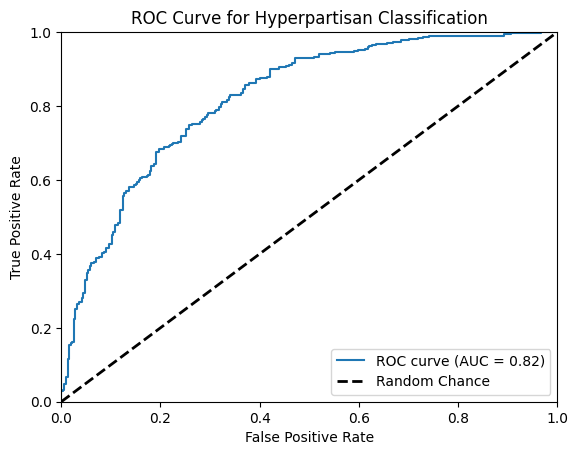

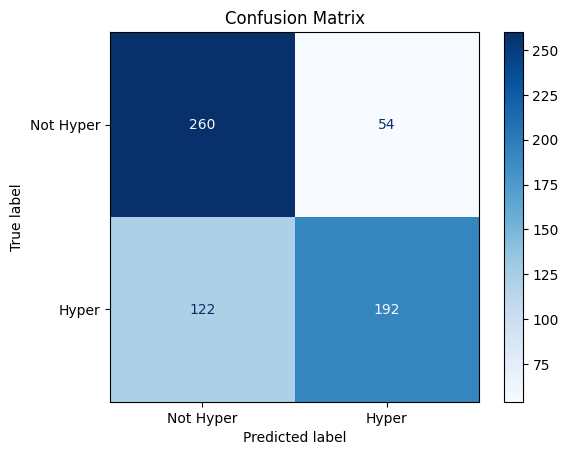


--- TF-IDF(2000) + Style + scale_weight ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:40:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.74
Balanced Accuracy: 0.74
Precision: 0.80
Recall: 0.64
F1: 0.71
AUC: 0.83


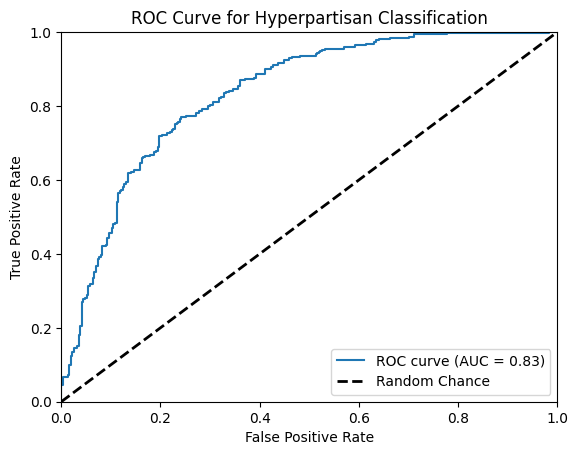

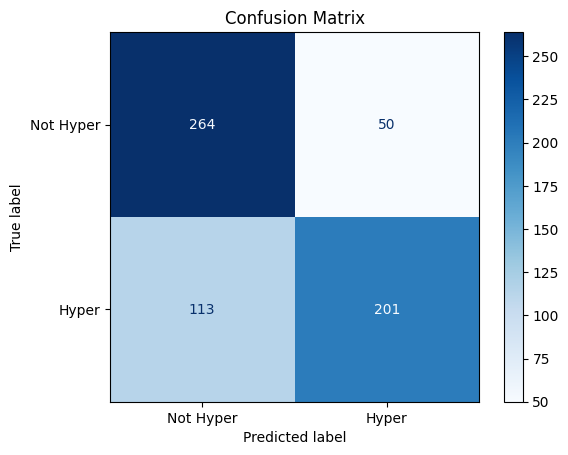


--- TF-IDF(2000) + Style + ROS ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.82
Recall: 0.66
F1: 0.73
AUC: 0.83


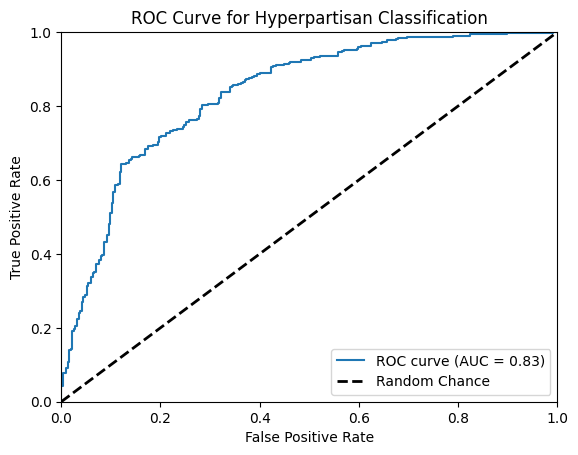

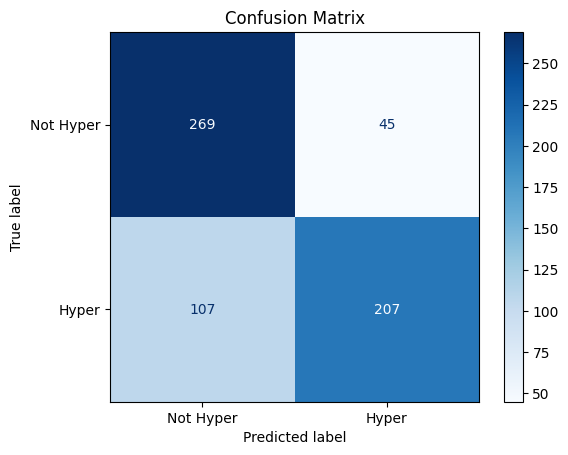


--- TF-IDF(2000) + Style + ROS + Lemmatized ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.75
Balanced Accuracy: 0.75
Precision: 0.82
Recall: 0.64
F1: 0.72
AUC: 0.82


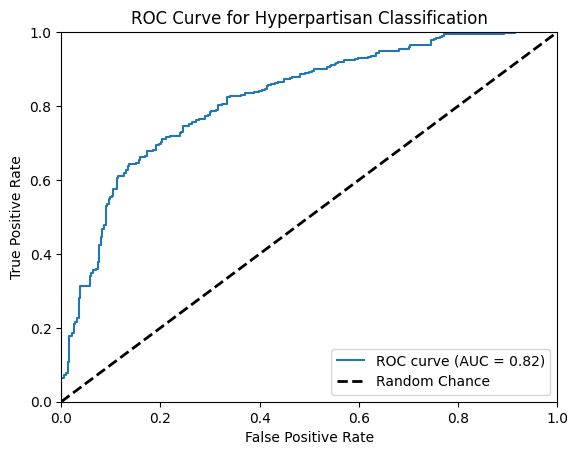

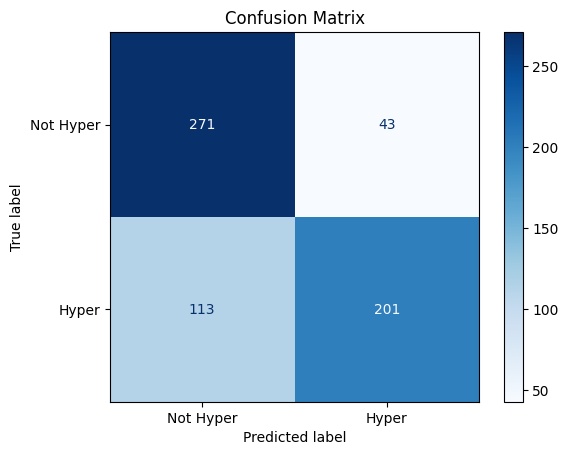


--- TF-IDF(3000) + Style + ROS + Lemmatized ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.74
Balanced Accuracy: 0.74
Precision: 0.81
Recall: 0.63
F1: 0.71
AUC: 0.82


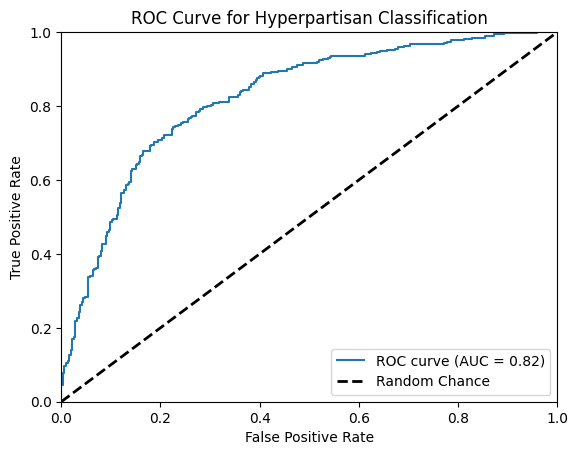

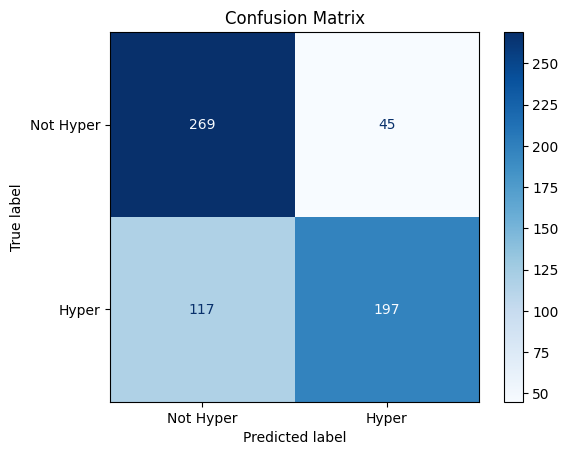

In [43]:
for exp in experiments:
    print(f"\n--- {exp['name']} ---")

    df_train = exp["train_df"]
    df_test = exp["test_df"]
    X_train_text = df_train[exp["text_col"]]
    X_test_text = df_test[exp["text_col"]]
    y_train = df_train["label"]
    y_test = df_test["label"]

    # Vectorize
    vectorizer = TfidfVectorizer(max_features=exp["max_features"], stop_words="english", ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    # Style features
    if exp["style"]:
        scaler = MinMaxScaler()
        X_train_style = csr_matrix(scaler.fit_transform(df_train[style_features]))
        X_test_style = csr_matrix(scaler.transform(df_test[style_features]))
        X_train_comb = hstack([X_train_vec, X_train_style])
        X_test_comb = hstack([X_test_vec, X_test_style])
    else:
        X_train_comb = X_train_vec
        X_test_comb = X_test_vec

    # Balancing
    if exp["balancing"] == "ros":
        ros = RandomOverSampler(random_state=0)
        X_train_final, y_train_final = ros.fit_resample(X_train_comb, y_train)
        scale_weight = 1
    else:
        X_train_final = X_train_comb
        y_train_final = y_train
        # weight = (# negative / # positive)
        scale_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    # Train XGBoost
    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_weight,
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=0
    )

    clf.fit(X_train_final, y_train_final)
    y_pred = clf.predict(X_test_comb)
    y_proba = clf.predict_proba(X_test_comb)[:, 1]

    metrics(y_test, y_pred, y_proba)
    plot_confusion_matrix(y_test, y_pred)
    store_metrics(results, "XGBoost", exp["name"], y_test, y_pred, y_proba)

In [48]:
# Save all results to CSV
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Table ===")
print(results_df.to_string(index=False))


=== Model Comparison Table ===
  Model                                   Setup  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score   AUC
XGBoost             TF-IDF(2000) + scale_weight     0.720              0.720      0.780   0.611     0.686 0.821
XGBoost     TF-IDF(2000) + Style + scale_weight     0.740              0.740      0.801   0.640     0.712 0.832
XGBoost              TF-IDF(2000) + Style + ROS     0.758              0.758      0.821   0.659     0.731 0.834
XGBoost TF-IDF(2000) + Style + ROS + Lemmatized     0.752              0.752      0.824   0.640     0.720 0.820
XGBoost TF-IDF(3000) + Style + ROS + Lemmatized     0.742              0.742      0.814   0.627     0.709 0.822


# Analyze

ROS outperformed scale_pos_weight

    TF-IDF(2000) + Style + ROS had higher F1 (0.731) and AUC (0.834) than scale-weighted alternatives

    Shows that synthetic balancing was more effective than weighting for this task

 TF-IDF(2000) still the sweet spot

    3000 didn’t help — actually dropped slightly (F1: 0.709)

    Same as Random Forest: 2000 is the right size

 Stylistic features matter

    Style consistently boosted performance across all configs

    Especially noticeable when combined with ROS or class weight

 Lemmatization adds little or nothing

    Sometimes slightly hurts precision or recall

    Not worth the extra preprocessing for XGBoost

In [53]:
result = [row for row in results if row["Setup"] == "TF-IDF(2000) + Style + ROS"]
df_single = pd.DataFrame(result)
df_single.to_csv("results/byarticleBaseline_results_sepTest.csv", mode='a', index=False, header=False)


=== All Setup Names in Results ===
- TF-IDF(2000) + Style + ROS
- TF-IDF(2000) + Style + ROS + Lemmatized
- TF-IDF(2000) + Style + scale_weight
- TF-IDF(2000) + scale_weight
- TF-IDF(3000) + Style + ROS + Lemmatized
[{'Model': 'XGBoost', 'Setup': 'TF-IDF(2000) + Style + ROS', 'Accuracy': 0.758, 'Balanced Accuracy': np.float64(0.758), 'Precision': 0.821, 'Recall': 0.659, 'F1 Score': 0.731, 'AUC': np.float64(0.834)}]
